In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

dataset_dir = "/content/drive/MyDrive/braai_cnn/"
dataset_path = dataset_dir + "ztf_dataset_split.npz"
data = np.load(dataset_path)
data

NpzFile '/content/drive/MyDrive/braai_cnn/ztf_dataset_split.npz' with keys: X_flat_train, X_flat_test, X_train, X_test, y_train...

In [3]:
# X
X_flat_test = data["X_flat_test"]
X_test = data["X_test"]

# y
y_train = data["y_train"]
y_test = data["y_test"]

X_flat_test.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 11907), (9592, 3, 63, 63), (28776,), (9592,))

In [4]:
unique_values, counts = np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Value {value}: {count}")

Value 0: 20274
Value 1: 18094


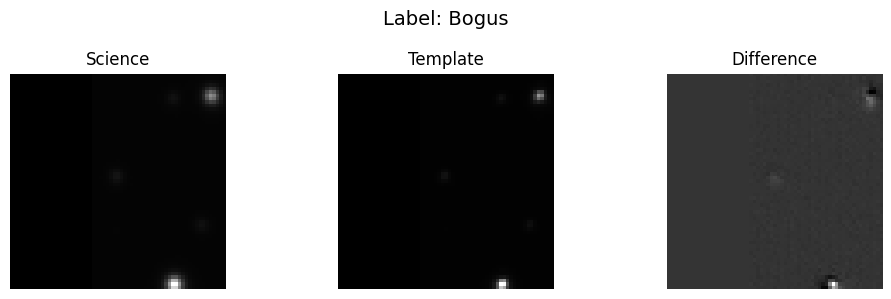

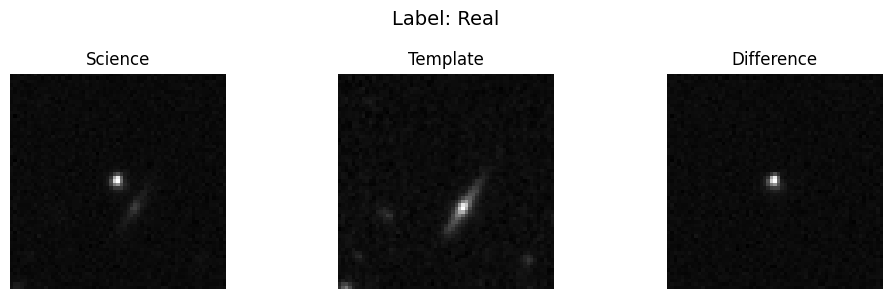

In [5]:
import matplotlib.pyplot as plt

def plot_img(sample, label):
  channels = ['Science', 'Template', 'Difference']
  fig, axs = plt.subplots(1, 3, figsize=(10, 3))
  for i in range(3):
    axs[i].imshow(sample[i], cmap='gray')
    axs[i].set_title(channels[i])
    axs[i].axis('off')

  fig.suptitle(f"Label: {'Real' if label == 1 else 'Bogus'}", fontsize=14)
  plt.tight_layout()
  plt.show()

plot_img(X_test[0], y_test[0])
plot_img(X_test[1], y_test[1])

## Load models and preds

### Logistic Regression

In [6]:
import pickle
models_dir = "/content/drive/MyDrive/braai_cnn/models/"

with open(models_dir + 'lrc_model.pkl', 'rb') as file:
  lrc_model = pickle.load(file)

lrc_probs = lrc_model.predict_proba(X_flat_test)[:, 1]
lrc_preds = (lrc_probs > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Random Forest

In [7]:
with open(models_dir + 'rfc_model.pkl', 'rb') as file:
  rfc_model = pickle.load(file)

rfc_probs = rfc_model.predict_proba(X_flat_test)[:, 1]
rfc_preds = (rfc_probs > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### PyTorch CNN

In [8]:
import os
os.chdir(dataset_dir)

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [11]:
from pt_cnn_layers import PyTorchCNN

pytorch_cnn = PyTorchCNN().to(device)
state = torch.load('models/pytorch_cnn.pt', map_location=device)
pytorch_cnn.load_state_dict(state['model'])
pytorch_cnn.eval()

PyTorchCNN(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [12]:
batch_size = 64
num_samples_tensor = X_test_tensor.shape[0]
pt_probs = []

with torch.no_grad():
  for i in range(0, num_samples_tensor, batch_size):
    batch = X_test_tensor[i : i+batch_size]
    pred = pytorch_cnn(batch)
    pt_probs.append(pred.cpu())

pt_probs = torch.cat(pt_probs).squeeze().numpy()
pt_preds = (pt_probs > 0.5).astype(int)

### Numpy CNN

In [13]:
import cupy as cp
X_test_cp = cp.array(X_test)

In [14]:
from np_cnn_layers import NumpyCNN

np_cnn = NumpyCNN()
np_cnn.load("models/numpy_cnn.npz", (16, 3, 63, 63))

/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Model from models/numpy_cnn.npz loaded into NumpyCNN


In [16]:
batch_size = 16
num_samples_cp = X_test_cp.shape[0]
cp_probs = []

for i in range(0, num_samples_cp, batch_size):
  batch = X_test_cp[i : i+batch_size]
  batch_preds = np_cnn.predict(batch)
  cp_probs.append(batch_preds)

cp_probs = cp.asnumpy(cp.concatenate(cp_probs, axis=0))
cp_probs = cp_probs.flatten()
cp_preds = (cp_probs > 0.5).astype(int)

## Evaluate

In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

def eval_model(y_true, y_pred, y_probs):
  return {
      "Accuracy": accuracy_score(y_true, y_pred),
      "Precision": precision_score(y_true, y_pred),
      "Recall": recall_score(y_true, y_pred),
      "F1 Score": f1_score(y_true, y_pred),
      "ROC AUC": roc_auc_score(y_true, y_probs),
      "Confusion Matrix": confusion_matrix(y_true, y_pred)
  }

In [18]:
results_lrc = eval_model(y_test, lrc_preds, lrc_probs)
results_rfc = eval_model(y_test, rfc_preds, rfc_probs)
results_pt = eval_model(y_test, pt_preds, pt_probs)
results_cp = eval_model(y_test, cp_preds, cp_probs)

In [19]:
import pandas as pd

metrics_df = pd.DataFrame([
    results_lrc,
    results_rfc,
    results_cp,
    results_pt
], index=["Logistic Regression", "Random Forest", "NumPy CNN", "PyTorch CNN"])

metrics_df.drop(columns=["Confusion Matrix"], inplace=True)

metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.661697,0.644049,0.631660,0.637794,0.711283
Random Forest,0.775021,0.771652,0.742649,0.756872,0.855148
NumPy CNN,0.801710,0.758634,0.849878,0.801668,0.890236
PyTorch CNN,0.826105,0.799580,0.842361,0.820413,0.910472


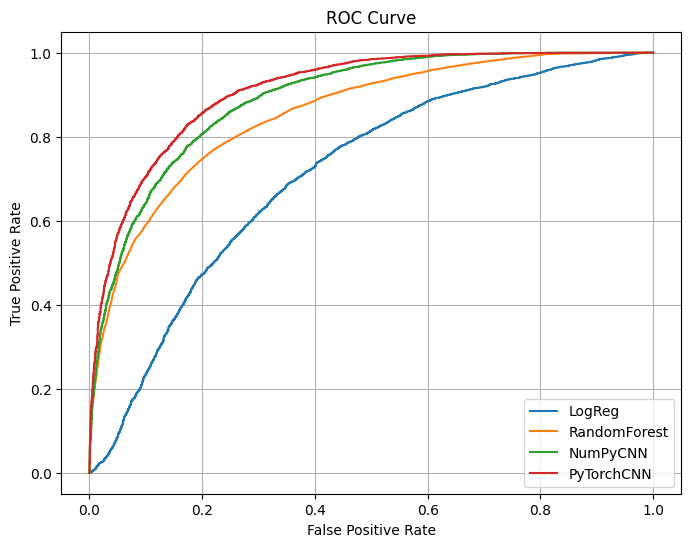

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_curves(y_true, model_outputs, labels, curve_type):
  plt.figure(figsize=(8, 6))

  for y_probs, label in zip(model_outputs, labels):
    if curve_type == "ROC":
      fpr, tpr, thresholds = roc_curve(y_true, y_probs)
      plt.plot(fpr, tpr, label=label)
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
    else:
      precision, recall, _ = precision_recall_curve(y_true, y_probs)
      plt.plot(recall, precision, label=label)
      plt.xlabel("Recall")
      plt.ylabel("Precision")

  plt.title(f"{curve_type} Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_curves(y_test, [lrc_probs, rfc_probs, cp_probs, pt_probs],
            ["LogReg", "RandomForest", "NumPyCNN", "PyTorchCNN"],
            curve_type='ROC')

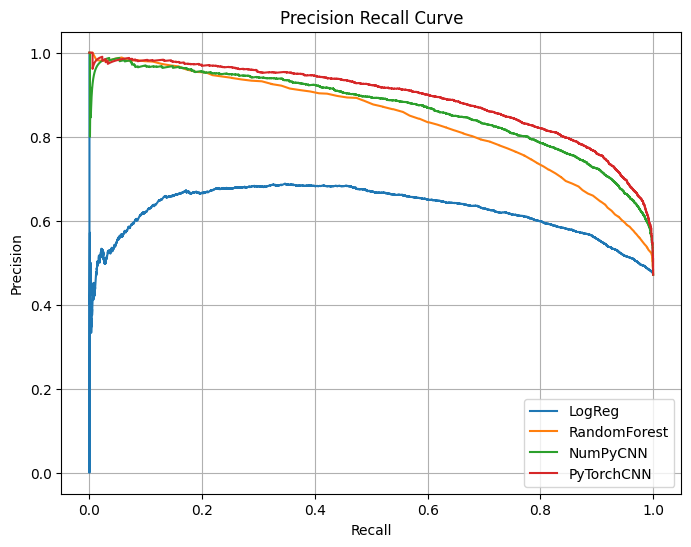

In [21]:
plot_curves(y_test, [lrc_probs, rfc_probs, cp_probs, pt_probs],
            ["LogReg", "RandomForest", "NumPyCNN", "PyTorchCNN"],
            curve_type='Precision Recall')

In [22]:
def plot_fpr_fnr(y_true, y_probs, model_name):
    thresholds = np.linspace(0, 1, 1000)
    fnr = []
    fpr = []
    misclassification_error = []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        misclassification_error.append((fp + fn) / (fp + fn + tp + tn))

    fnr = np.array(fnr)
    fpr = np.array(fpr)
    misclassification_error = np.array(misclassification_error)

    i = np.argmin(np.abs(fpr - fnr))
    intersect_thresh = thresholds[i]
    intersect_fnr = fnr[i]
    intersect_fpr = fpr[i]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fnr * 100, label="False Negative Rate (FNR)", color='blue')
    plt.plot(thresholds, fpr * 100, label="False Positive Rate (FPR)", color='orange')
    plt.plot(thresholds, misclassification_error * 100, '--', color='gray', label='Mean misclassification error')

    plt.axvline(intersect_thresh, color='black')
    plt.text(intersect_thresh + 0.01, max(fnr[i], fpr[i]) * 100,
             f"{intersect_fnr*100:.1f}% FNR\n{intersect_fpr*100:.1f}% FPR", verticalalignment='bottom')

    plt.xlim(0, 1)
    plt.ylim(0.05, 100)
    plt.yscale('log')
    plt.xlabel("RB score threshold")
    plt.ylabel("Cumulative percentage")
    plt.title(f"FNR vs FPR Curve — {model_name}")
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()
    plt.show()

    return {
        "Intersection Threshold": intersect_thresh,
        "FNR at Intersection": intersect_fnr,
        "FPR at Intersection": intersect_fpr
    }


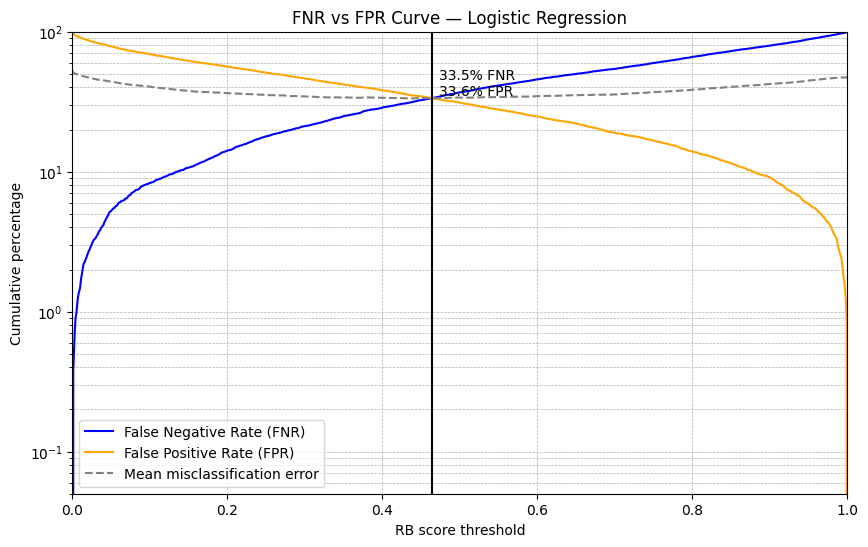

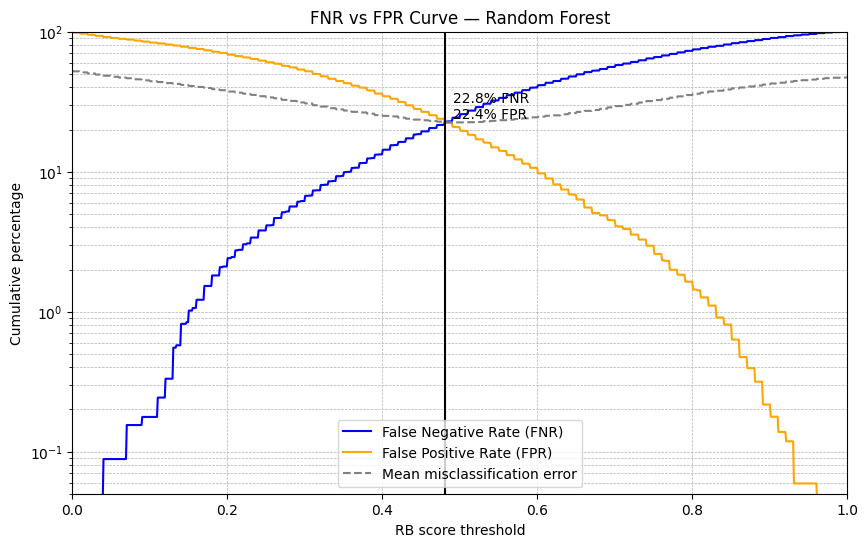

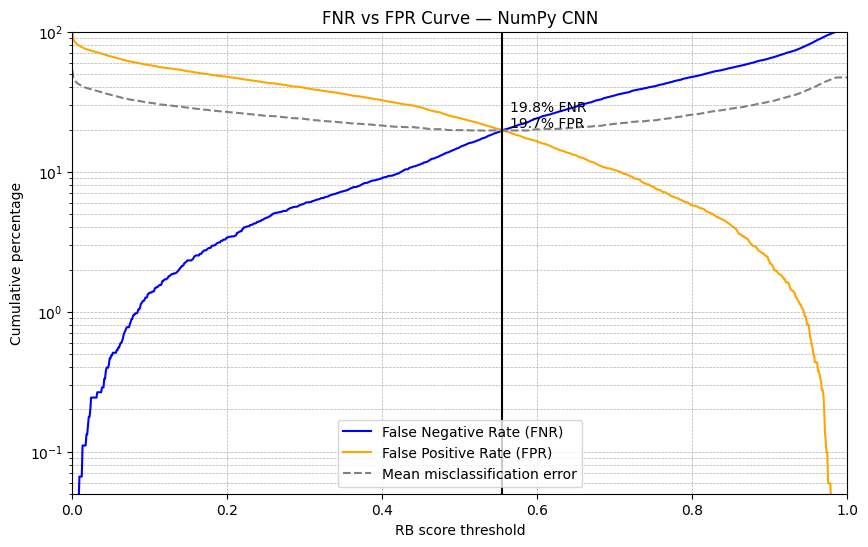

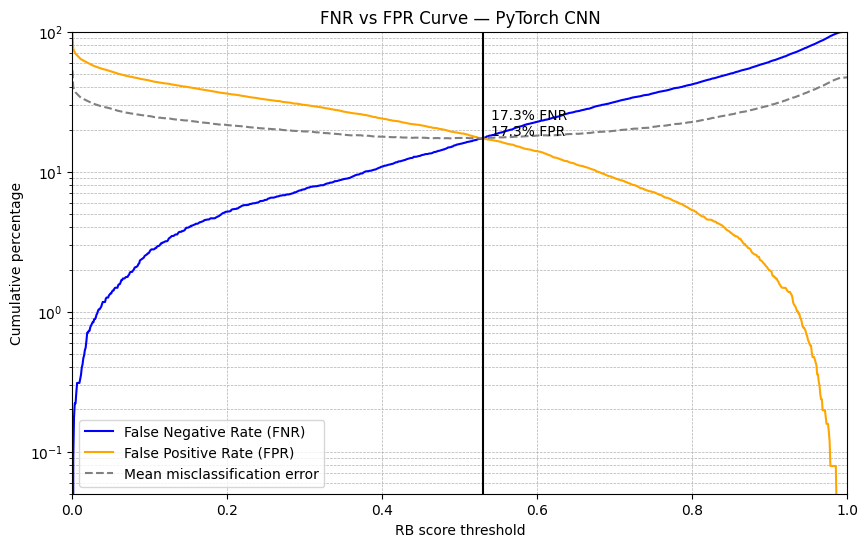

In [23]:
fnr_fpr_lrc = plot_fpr_fnr(y_test, lrc_probs, "Logistic Regression")
fnr_fpr_rfc = plot_fpr_fnr(y_test, rfc_probs, "Random Forest")
fnr_fpr_cp = plot_fpr_fnr(y_test, cp_probs, "NumPy CNN")
fnr_fpr_pt = plot_fpr_fnr(y_test, pt_probs, "PyTorch CNN")

In [24]:
for i, result in enumerate([fnr_fpr_lrc, fnr_fpr_rfc, fnr_fpr_cp, fnr_fpr_pt]):
    metrics_df.loc[metrics_df.index[i], "FNR=FPR Threshold"] = result["Intersection Threshold"]
    metrics_df.loc[metrics_df.index[i], "FNR@Threshold (%)"] = result["FNR at Intersection"] * 100
    metrics_df.loc[metrics_df.index[i], "FPR@Threshold (%)"] = result["FPR at Intersection"] * 100

metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,FNR=FPR Threshold,FNR@Threshold (%),FPR@Threshold (%)
Logistic Regression,0.661697,0.644049,0.631660,0.637794,0.711283,0.463463,33.473358,33.556915
Random Forest,0.775021,0.771652,0.742649,0.756872,0.855148,0.480480,22.816715,22.371276
NumPy CNN,0.801710,0.758634,0.849878,0.801668,0.890236,0.554555,19.765642,19.668574
PyTorch CNN,0.826105,0.799580,0.842361,0.820413,0.910472,0.529530,17.311519,17.261787


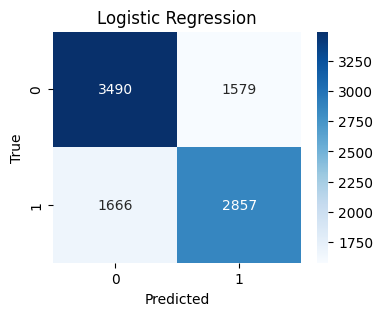

In [25]:
import seaborn as sns

def plot_confusion(matrix, title):
  plt.figure(figsize=(4, 3))
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(title)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

plot_confusion(results_lrc["Confusion Matrix"], "Logistic Regression")

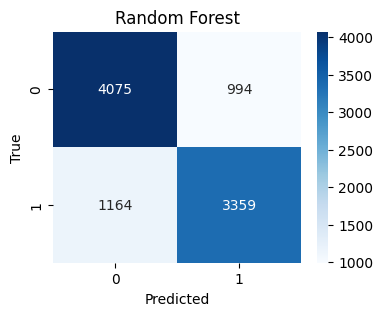

In [26]:
plot_confusion(results_rfc["Confusion Matrix"], "Random Forest")

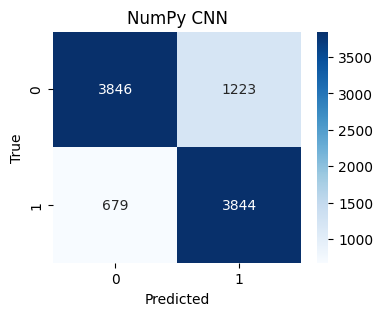

In [27]:
plot_confusion(results_cp["Confusion Matrix"], "NumPy CNN")

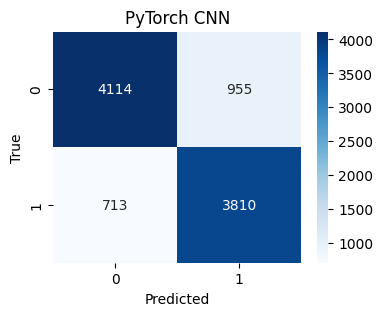

In [28]:
plot_confusion(results_pt["Confusion Matrix"], "PyTorch CNN")

In [29]:
import time

timings = {}

# Log Reg
start = time.time()
_ = lrc_model.predict_proba(X_flat_test)[:, 1]
timings["Logistic Regression"] = time.time() - start

# Random Forest
start = time.time()
_ = rfc_model.predict_proba(X_flat_test)[:, 1]
timings["Random Forest"] = time.time() - start

# PyTorch CNN
start = time.time()
pt_probs_timing = []
with torch.no_grad():
  for i in range(0, num_samples_tensor, batch_size):
    batch = X_test_tensor[i : i+batch_size]
    pred = pytorch_cnn(batch)
    pt_probs_timing.append(pred.cpu())
_ = torch.cat(pt_probs_timing).squeeze().numpy()
timings["PyTorch CNN"] = time.time() - start

# NumPy CNN
start = time.time()
cp_probs_timing = []
for i in range(0, num_samples_cp, batch_size):
  batch = X_test_cp[i : i+batch_size]
  batch_preds = np_cnn.predict(batch)
  cp_probs_timing.append(batch_preds)
_ = cp.asnumpy(cp.concatenate(cp_probs_timing, axis=0)).flatten()
timings["NumPy CNN"] = time.time() - start

metrics_df["Inference Time"] = metrics_df.index.map(timings)

metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,FNR=FPR Threshold,FNR@Threshold (%),FPR@Threshold (%),Inference Time
Logistic Regression,0.661697,0.644049,0.631660,0.637794,0.711283,0.463463,33.473358,33.556915,0.291989
Random Forest,0.775021,0.771652,0.742649,0.756872,0.855148,0.480480,22.816715,22.371276,0.573402
NumPy CNN,0.801710,0.758634,0.849878,0.801668,0.890236,0.554555,19.765642,19.668574,78.514957
PyTorch CNN,0.826105,0.799580,0.842361,0.820413,0.910472,0.529530,17.311519,17.261787,0.421247


In [31]:
metrics_df.to_csv("/content/drive/MyDrive/braai_cnn/model_metrics.csv", index=False)